In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sys
import os
import scipy.stats as stats
from fears.population import Population
from fears.utils import plotter, fitness
from matplotlib import colors
from spatialentropy import leibovici_entropy, altieri_entropy
from datetime import date

In [226]:
sys.path.append("./utils")
from DoseResponseModel import DoseResponseModel

jarFileName = "./HAL_dose_response.jar"

consumpt_rate = [10**-4,0.001,0.01,0.1,0.5]

indx = 0
n_replicates = 10

# get today's date
today = date.today()

date_str = today.strftime("%Y-%m-%d")

data_folder = "./data/" + date_str

for cr in consumpt_rate:
    modelConfigDic = {'xDim':100,"yDim":100,'nTSteps':5000,"saveModelState":True,
                    "imageFrequency":-1,"consumpRate":cr,
                    "nReplicates":n_replicates,"dt":0.1,"initialGeometry":"square","initialDensity":0.01,
                    "saveFinalDiffImg":True,"saveFinalDiffGrid":True,"saveFinalPopGrid":True}

    dataDir = data_folder + "/cellCountDoseResponse_{}".format(indx)
    imgDir = "./data/doseResponseImages"

    myModel = DoseResponseModel(jarFileName = jarFileName, outDir=dataDir, imageOutDir=imgDir, **modelConfigDic)
    myModel.Simulate()
    indx += 1

In [5]:
# plot MSW
n_replicates = 10
data_folder = "./data/2023-08-02"
from fears.population import Population
from fears.utils import plotter
p = Population(death_model = None,n_allele=2,fitness_data='random')
p.drugless_rates = [1.28949852, 1.14399848, 1.22802236, 0.93619847]
p.ic50 = [-0.49205992, 1.76224515,  1.39341393,  2.84653598]

# fig,ax = plt.subplots(figsize=(5,3))
# fig,ax = plotter.plot_fitness_curves(p,ax=ax,fig=fig,
#                                       color_kwargs={'style':'solid',
#                                                     'n_colors':4,
#                                                     'palette':'colorblind'})

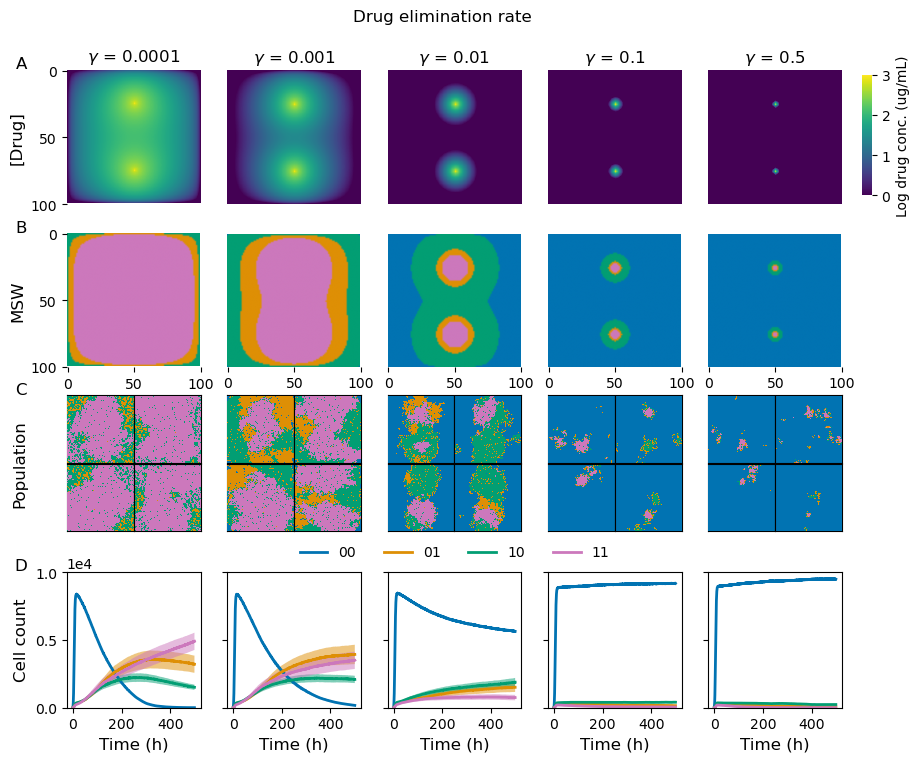

In [19]:
# plot everything in one figure
msw_map_list = []
pop_map_list = []
diffGridList = []

def get_most_fit_at_conc(data):
    most_fit_at_conc = np.zeros(data.shape)
    for z in range(data.shape[0]):
        for j in range(data.shape[1]):
            # conc = 10**data[z,j]
            conc = data[z,j]
            p_fit_list = p.gen_fit_land(conc)
            most_fit_at_conc[z,j] = int((np.argmax(p_fit_list)))
    return most_fit_at_conc

consumpt_rate = [10**-4,0.001,0.01,0.1,0.5]
fig,ax_list = plt.subplots(ncols=len(consumpt_rate),nrows=3,figsize=(10,6))

img_t = np.zeros((100,100))

def get_cmap(most_fit_at_conc):
    cc = plotter.gen_color_cycler(style='solid',n_colors=4,palette='colorblind')
    cc_dict = cc.by_key()
    c = cc_dict['color']

    indx = [list(set(most_fit_at_conc.flatten()))]
    indx = [int(i) for i in indx]
    c = [c[i] for i in indx]

    cmap = colors.ListedColormap(c)
    bounds=indx
    norm = colors.BoundaryNorm(bounds, cmap.N)
    return cmap,norm

for i,rate in enumerate(consumpt_rate):
    # plot drug grid
    dataDir = data_folder + "/cellCountDoseResponse_{}".format(i)
    dataFile = dataDir + '/RepId_0_diffGrid.csv'
    data = pd.read_csv(dataFile)
    for index,row in data.iterrows():
        if row['field'] > 0:
            img_t[int(row['x']),int(row['y'])] = row['field']
    diffGridList.append(img_t)
    img_t_log = np.log10(img_t)
    # ax[i].set_xlim(0,90)
    ax = ax_list[0,i]
    drug_img = ax.imshow(img_t_log,cmap='viridis',vmin=0,vmax=3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.set_title("$\gamma$ = " + str(rate))

    # plot msw grid
    most_fit_at_conc = get_most_fit_at_conc(img_t)
    cc = plotter.gen_color_cycler(style='solid',n_colors=4,palette='colorblind')
    cc_dict = cc.by_key()
    c = cc_dict['color']

    indx = list(set(most_fit_at_conc.flatten()))
    indx = [int(i) for i in indx]
    c = [c[i] for i in indx]

    cmap = colors.ListedColormap(c)
    bounds=indx
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    ax = ax_list[1,i]
    msw_img = ax.imshow(most_fit_at_conc,cmap=cmap,
              interpolation='gaussian',interpolation_stage='rgba')
    
    msw_map_list.append(most_fit_at_conc)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # plot population grid
    dataDir = data_folder + "/cellCountDoseResponse_{}".format(i)
    img_list = []
    for j in range(10):
        img_t = np.zeros((100,100))
        dataFile = dataDir + '/RepId_{}_popGrid.csv'.format(j)
        data = pd.read_csv(dataFile)
        for index,row in data.iterrows():
            # if row['field'] > 0:
            img_t[int(row['x']),int(row['y'])] = row['genotype']
        img_list.append(img_t)
    
    # LUQ
    ax_t = ax_list[2,i].inset_axes([0,0.5,0.5,0.5])
    ax_t.imshow(img_list[0],cmap=cmap)
    ax_t.set_xticks([])
    ax_t.set_yticks([])
    # ax_t.spines['right'].set_visible(False)
    ax_t.spines['top'].set_visible(False)
    ax_t.spines['left'].set_visible(False)
    # ax_t.spines['bottom'].set_visible(False)
    # RUQ
    ax_t = ax_list[2,i].inset_axes([0.5,0.5,0.5,0.5])
    ax_t.imshow(img_list[4],cmap=cmap)
    ax_t.set_xticks([])
    ax_t.set_yticks([])
    ax_t.spines['right'].set_visible(False)
    ax_t.spines['top'].set_visible(False)
    # ax_t.spines['left'].set_visible(False)
    # ax_t.spines['bottom'].set_visible(False)
    # LLQ
    ax_t = ax_list[2,i].inset_axes([0,0,0.5,0.5])
    ax_t.imshow(img_list[2],cmap=cmap)
    ax_t.set_xticks([])
    ax_t.set_yticks([])
    # ax_t.spines['right'].set_visible(False)
    # ax_t.spines['top'].set_visible(False)
    ax_t.spines['left'].set_visible(False)
    ax_t.spines['bottom'].set_visible(False)
    # RLQ
    ax_t = ax_list[2,i].inset_axes([0.5,0,0.5,0.5])
    ax_t.imshow(img_list[3],cmap=cmap)
    ax_t.set_xticks([])
    ax_t.set_yticks([])
    ax_t.spines['right'].set_visible(False)
    # ax_t.spines['top'].set_visible(False)
    # ax_t.spines['left'].set_visible(False)
    ax_t.spines['bottom'].set_visible(False)
    # img_t = np.log10(img_t)
    ax_list[2,i].set_xticks([])
    ax_list[2,i].set_yticks([])
    # ax.imshow(img_t,vmin=0,vmax=3,cmap=cmap)
    # ax[i].set_xlim(0,90)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    pop_map_list.append(img_t)

# manage x and y ticks

# clear all ticks

for i in range(len(consumpt_rate)):
    ax = ax_list[0,i]
    ax.set_xticks([])
    # ax.set_xticklabels([])
    ax.set_yticks([])
    # ax.set_yticklabels([])
    ax = ax_list[1,i]
    ax.set_xticks([])
    # ax.set_xticklabels([])
    ax.set_yticks([])
    ax = ax_list[2,i]
    ax.set_xticks([])
    # ax.set_xticklabels([])
    ax.set_yticks([])
    # ax.set_yticklabels([])

# add y ticks to row 1 and 2
ax = ax_list[0,0]
ax.set_yticks([0,50,100])
ax = ax_list[1,0]
ax.set_yticks([0,50,100])

# add x ticks to row 2
for i in range(len(consumpt_rate)):
    ax = ax_list[1,i]
    ax.set_xticks([0,50,100])
    # ax.xaxis.set_tick_params()

# add colorbar for drug grid
cbar_ax = fig.add_axes([0.92, 0.67, 0.01, 0.2])
cbar = fig.colorbar(drug_img, cax=cbar_ax,label='Log drug conc. (ug/mL)')
cbar.outline.set_visible(False)

# add another row for timetraces using inset axes

cc = plotter.gen_color_cycler(style='solid',n_colors=4,palette='colorblind')

# ax.set_prop_cycle(cc) 
inset_axes_list = []

for i in range(len(consumpt_rate)):
    ax = ax_list[2,i]
    pos = ax.get_position()

    axins = ax.inset_axes((0,-1.3,1,1))
    dataDir = data_folder + "/cellCountDoseResponse_{}".format(i)


    axins.set_prop_cycle(cc)
    counts_dict = {}

    for j in range(n_replicates):
        dataFile = dataDir + '/RepId_{}.csv'.format(j)
        data = pd.read_csv(dataFile)
        gen_indx = 0
        for col in data.columns[3:7]:
            ts = np.array(data[col])
            if gen_indx not in counts_dict.keys():
                counts_dict[gen_indx] = np.array([ts])
            else:
                counts_dict[gen_indx] = np.append(counts_dict[gen_indx],np.array([ts]),axis=0)
            # counts_dict[gen_indx] = 
            # axins.plot(data['Time'],data[col],label=col,linewidth=2,alpha=0.6)
            gen_indx += 1
    
    for gen_indx in counts_dict.keys():
        mean = np.mean(counts_dict[gen_indx],axis=0)
        err = np.std(counts_dict[gen_indx],axis=0)/np.sqrt(n_replicates)
        axins.plot(data['Time'],mean,label=gen_indx,linewidth=2)
        axins.fill_between(data['Time'],mean-err,mean+err,alpha=0.5)

    axins.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
    axins.set_xlabel('Time (h)',fontsize=12)

    inset_axes_list.append(axins)

handles, labels = inset_axes_list[2].get_legend_handles_labels()
labels = ['00','01','10','11']
inset_axes_list[2].legend(handles,labels,frameon=False,ncol=4,loc=[-0.7,1.05])

# make sure all of the ylimits are the same
ymax = 0
for ax in inset_axes_list:
    if ax.get_ylim()[1] > ymax:
        ymax = ax.get_ylim()[1]

for ax in inset_axes_list:
    ax.set_ylim(0,ymax)

for ax in inset_axes_list[1:]:
    ax.set_yticklabels([])

inset_axes_list[0].set_ylabel('Cell count',fontsize=12)

ax_list[0,0].set_ylabel('[Drug]',fontsize=12)
ax_list[1,0].set_ylabel('MSW',fontsize=12)
ax_list[2,0].set_ylabel('Population',fontsize=12,labelpad=25)
# ax_list[-1,2].set_xlabel('x',fontsize=12)
# ax_list[1,0].set_ylabel('y',fontsize=12)

label_list = ['A','B','C','D']
for i in range(len(label_list)-1):
    ax = ax_list[i,0]
    ax.text(-0.3,1.1,label_list[i],transform=ax.transAxes,
            fontsize=12,va='top',ha='right')

inset_axes_list[0].text(-0.3,1.1,label_list[-1],transform=inset_axes_list[0].transAxes,
            fontsize=12,va='top',ha='right')

fig.suptitle('Drug elimination rate',fontsize=12)

fig.savefig('figures/simulation_example_results.pdf',dpi=300,bbox_inches='tight')
# fig.suptitle('Varying field elimination rate',fontsize=12)


In [16]:
# compute altieri entropy for MSW and population

def get_most_fit_at_conc_1d(data):
    most_fit_at_conc = np.zeros(data.shape)
    for z in range(data.shape[0]):
        # conc = 10**data[z,j]
        conc = data[z]
        p_fit_list = p.gen_fit_land(conc)
        most_fit_at_conc[z] = int((np.argmax(p_fit_list)))
    return most_fit_at_conc

n_replicates = 10
msw_entropy = []
pop_entropy = []
pop_entropy_list = []
consumpt_rate_list = []
for i,rate in enumerate(consumpt_rate):
    dataDir = data_folder + "/cellCountDoseResponse_{}".format(i)
    diffGridFile = dataDir + '/RepId_0_diffGrid.csv'
    diffGrid = pd.read_csv(diffGridFile)
    msw_list = get_most_fit_at_conc_1d(np.array(diffGrid['field']))
    msw_list = np.array(msw_list, dtype=int)
    points = np.array(diffGrid[['x','y']])
    e_msw = altieri_entropy(points, msw_list)
    pop_entropy_list_t = []
    for j in range(n_replicates):
        dataDir = data_folder + "/cellCountDoseResponse_{}".format(i)
        diffGridFile = dataDir + '/RepId_{}_popGrid.csv'.format(j)
        diffGrid = pd.read_csv(diffGridFile)
        point = np.array(diffGrid[['x','y']])
        types = np.array(diffGrid['genotype'])
        e_pop = altieri_entropy(point, types)
        pop_entropy.append(e_pop.entropy)
        pop_entropy_list_t.append(e_pop.entropy)
        msw_entropy.append(e_msw.entropy)
        consumpt_rate_list.append(rate)
    pop_entropy_list.append(pop_entropy_list_t)

In [17]:
# analyze MSW share versus population share

def get_most_fit_at_conc_1d(data):
    most_fit_at_conc = np.zeros(data.shape)
    for z in range(data.shape[0]):
        # conc = 10**data[z,j]
        conc = data[z]
        p_fit_list = p.gen_fit_land(conc)
        most_fit_at_conc[z] = int((np.argmax(p_fit_list)))
    return most_fit_at_conc

pop_count = []
msw_count = []

genotypes = [0,1,2,3]

genotype_list = []
consumpt_list = []

for i,rate in enumerate(consumpt_rate):
    dataDir = data_folder + "/cellCountDoseResponse_{}".format(i)
    
    for j in range(n_replicates):
        # dataDir = "./data/cellCountDoseResponse_{}".format(i)
        popGridFile = dataDir + '/RepId_{}_popGrid.csv'.format(j)
        diffGridFile = dataDir + '/RepId_{}_diffGrid.csv'.format(j)
        popGrid = pd.read_csv(popGridFile)
        pop_types = np.array(popGrid['genotype'])

        diffGrid = pd.read_csv(diffGridFile)
        field = diffGrid['field']
        
        most_fit_at_conc = get_most_fit_at_conc_1d(field)
        for g in genotypes:
            pop_count.append(np.sum(pop_types==g))
            msw_count.append(np.sum(most_fit_at_conc==g))
            # color_list.append(g)
            genotype_list.append(g)
            consumpt_list.append(rate)


# ax.legend(*sc.legend_elements(),frameon=False)

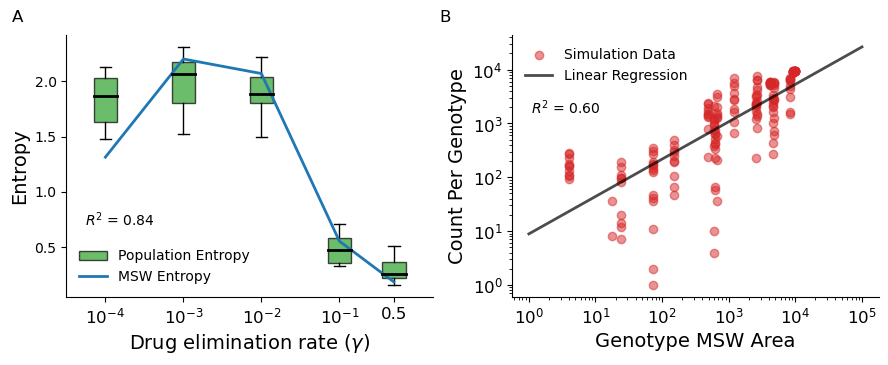

In [18]:
# fig,ax = plt.subplots()

# consumpt_rate_list = np.array(consumpt_rate_list)
# consumpt_rate_list[consumpt_rate_list>0] = np.log10(consumpt_rate_list[consumpt_rate_list>0])
# consumpt_rate_list[consumpt_rate_list==0] = -4
consumpt_rate_log = np.array(consumpt_rate_list)
consumpt_rate_log[consumpt_rate_log>0] = np.log10(consumpt_rate_log[consumpt_rate_log>0])
consumpt_rate_log[consumpt_rate_log==0] = -4

# sc = ax.scatter(msw_entropy,pop_entropy,c=consumpt_rate_log,cmap='viridis',s=30)
# ax.set_xlabel('MSW Entropy',fontsize=14)
# ax.set_ylabel('Population Entropy',fontsize=14)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.legend(*sc.legend_elements(),frameon=False)

fig,ax_list = plt.subplots(ncols=2,figsize=(9,3.5))

ax = ax_list[0]
# ax.scatter(consumpt_rate_log,pop_entropy,label='Population Entropy',alpha=0.7)

medianprops = {'color': 'black', 'linewidth': 2}

bp0 = ax.boxplot(pop_entropy_list,positions=np.log10(consumpt_rate),
                 medianprops=medianprops,widths=0.3,patch_artist=True,
                 boxprops=dict(facecolor="tab:green",alpha=0.7))
# bp1["boxes"][0]
plot0 = ax.plot(consumpt_rate_log,msw_entropy,label='MSW Entropy',linewidth=2)
ax.set_xlabel('Drug elimination rate ($\gamma$)',fontsize=14)
ax.set_ylabel('Entropy',fontsize=14)

# get boxplot handles for legend
handles = [bp0["boxes"][0], plot0[0]]
labels = ['Population Entropy', 'MSW Entropy']
ax.legend(handles,labels,frameon=False,fontsize=10)

ax.set_xticks([-4,-3,-2,-1,np.log10(0.5)])
xt = ax.get_xticklabels()
# xt_pos = [t.get_position()[0] for t in xt]
# xt_pos = np.array(xt_pos)
# xt_pos = xt_pos[1:]
# ax.set_xticks(xt_pos)
ax.set_xticklabels(['$10^{-4}$','10$^{-3}$','10$^{-2}$','10$^{-1}$','0.5'],fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

res = stats.linregress(msw_entropy,pop_entropy)
# annotate with p value
r_sqr = res.rvalue**2
text = '$R^{2}$ = ' + '{:.2f}'.format(r_sqr)
ax.annotate(text,xy=(0.05,0.27),xycoords='axes fraction',fontsize=10)
ax0 = ax
# fig,ax = plt.subplots()

# colormap = plt.cm.get_cmap('viridis')  # You can choose a different colormap if you prefer

# # Normalize your values to the range [0, 1] to match the colormap range
# norm = plt.Normalize(min(consumpt_rate), max(consumpt_rate))

# # Get the colors for each value based on the colormap
# colors = [colormap(norm(val)) for val in consumpt_list]

# sc = ax.scatter(msw_count,pop_count,c=colors, cmap=colormap)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.legend(*sc.legend_elements(),frameon=False);

ax = ax_list[1]

msw_count = np.array(msw_count)
pop_count = np.array(pop_count)

# nonzero_indx = np.where(msw_count>0 and pop_count>0)[0]
nonzero_indx = np.logical_and(msw_count>0,pop_count>0)

msw_count_nonzero = msw_count[nonzero_indx]
pop_count_nonzero = pop_count[nonzero_indx]

consumpt_list = np.array(consumpt_list)
consumpt_list_nonzero = consumpt_list[nonzero_indx]

for rate in consumpt_rate:
    indx = np.where(consumpt_list_nonzero == rate)[0]
    # xdata = np.log10(msw_count[indx])
    # ydata = np.log10(pop_count[indx])
    # xdata = msw_count[indx]
    # ydata = pop_count[indx]
    xdata = msw_count_nonzero[indx]
    ydata = pop_count_nonzero[indx]
    ax.scatter(xdata,ydata,color='tab:red',alpha=0.5,label='Simulation Data')

ax.set_xscale('log')
ax.set_yscale('log')
# ax.legend(frameon=False);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Genotype MSW Area',fontsize=14)
ax.set_ylabel('Count Per Genotype',fontsize=14) 

ax.tick_params(axis='both', which='major', labelsize=12)

fig.tight_layout()

res = stats.linregress(np.log10(msw_count_nonzero),np.log10(pop_count_nonzero))
xdata = np.linspace(0,5,100)
ydata = res.slope*xdata + res.intercept
ax.plot(10**xdata,10**ydata,color='black',label='Linear Regression',alpha=0.7,linewidth=2)
# xdata = np.linspace(1,5,100)
# ydata = res.slope*xdata + res.intercept
# ax.plot(xdata,ydata,color='tab:red',label='Slope: {:.2f}'.format(res.slope))
# get unique legend handles and labels
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),frameon=False,loc='upper left',fontsize=10)
# annotate p value

r_sqr = res.rvalue**2
text = '$R^{2}$ = ' + '{:.2f}'.format(r_sqr)
ax.annotate(text,xy=(0.05,0.7),xycoords='axes fraction',fontsize=10)

# annotate panel labels
ax_list[0].annotate('A',xy=(-0.15,1.05),xycoords='axes fraction',fontsize=12)
ax_list[1].annotate('B',xy=(-0.2,1.05),xycoords='axes fraction',fontsize=12)

fig.savefig('figures/msw_correlation.pdf',bbox_inches='tight')
# ax.legend(frameon=False)


# Messing around with selection coefficient

In [386]:
# def get_alpha(conc):
#     # find the most fit genotype
#     fl = p.gen_fit_land(conc)
#     g = np.argmax(fl)
#     # find the adjacent genotype with the highest fitness
#     neighbors = p.gen_neighbors(g)
#     fl = []
#     for gen in neighbors:
#         fl.append(fitness.gen_fitness(p,gen,conc))
#     neighbor_fit = np.max(fl)
#     current_fit = fitness.gen_fitness(p,g,conc)
#     # return neighbor_fit/current_fit
#     return (current_fit - neighbor_fit)/current_fit

# img_t = np.zeros((100,100))
# alpha_t = np.zeros((100,100))
# fig,ax_list = plt.subplots(nrows=2,ncols=5,sharex=True,sharey=True,figsize=(10,5))

# alpha_list = []

# for i,rate in enumerate(consumpt_rate):
#     dataDir = data_folder + "/cellCountDoseResponse_{}".format(i)
    
#     # for j in range(n_replicates):
#     diffGridFile = dataDir + '/RepId_0_diffGrid.csv'
#     diffGrid = pd.read_csv(diffGridFile)
#     field = diffGrid['field']

#     for index,row in diffGrid.iterrows():
#         if row['field'] > 0:
#             img_t[int(row['x']),int(row['y'])] = row['field']
#             alpha_t[int(row['x']),int(row['y'])] = get_alpha(row['field'])
    
#     alpha_list.append(alpha_t)

#     ax = ax_list[0,i]
#     ax.imshow(img_t,cmap='viridis')
#     ax = ax_list[1,i]
#     im1 = ax.imshow(alpha_t,cmap='viridis',vmin=0,vmax=0.56)

# # get the min and max alpha values
# alpha_min = np.min(alpha_list)
# alpha_max = np.max(alpha_list)

# # plot the alpha values
# # for i,rate in enumerate(consumpt_rate):
# #     ax = ax_list[1,i]
# #     im1 = ax.imshow(alpha_list[i],cmap='viridis',vmin=alpha_min,vmax=alpha_max)

# cbar_ax = fig.add_axes([0.92, 0.2, 0.01, 0.2])
# cbar = fig.colorbar(im1, cax=cbar_ax)